## Importing Necessary Modules

In [1]:
import numpy as np
import pandas as pd
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
import os
import random
from tqdm.auto import tqdm
import time

## Loading the Dataset

In [2]:
data_dir = r'C:\Users\vmurc\Desktop\VA Docs\Projects\csv_usa_100k' + '\\' #Establish location of data
print('The data is located at:')
print(data_dir, '\n')
data_list = os.listdir(data_dir) #List the data files
print('The data files are:')
print(data_list)

The data is located at:
C:\Users\vmurc\Desktop\VA Docs\Projects\csv_usa_100k\ 

The data files are:
['allergies.csv', 'careplans.csv', 'conditions.csv', 'devices.csv', 'encounters.csv', 'imaging_studies.csv', 'immunizations.csv', 'medications.csv', 'observations.csv', 'organizations.csv', 'patients.csv', 'payers.csv', 'payer_transitions.csv', 'procedures.csv', 'providers.csv', 'supplies.csv']


In [3]:
#Add data path to beginning of each element of list so that I can easily access them later
def prepend(list, str):
    str += '% s'
    new_list = [str % i for i in list]
    return new_list
new_list = prepend(data_list,data_dir)
new_list

['C:\\Users\\vmurc\\Desktop\\VA Docs\\Projects\\csv_usa_100k\\allergies.csv',
 'C:\\Users\\vmurc\\Desktop\\VA Docs\\Projects\\csv_usa_100k\\careplans.csv',
 'C:\\Users\\vmurc\\Desktop\\VA Docs\\Projects\\csv_usa_100k\\conditions.csv',
 'C:\\Users\\vmurc\\Desktop\\VA Docs\\Projects\\csv_usa_100k\\devices.csv',
 'C:\\Users\\vmurc\\Desktop\\VA Docs\\Projects\\csv_usa_100k\\encounters.csv',
 'C:\\Users\\vmurc\\Desktop\\VA Docs\\Projects\\csv_usa_100k\\imaging_studies.csv',
 'C:\\Users\\vmurc\\Desktop\\VA Docs\\Projects\\csv_usa_100k\\immunizations.csv',
 'C:\\Users\\vmurc\\Desktop\\VA Docs\\Projects\\csv_usa_100k\\medications.csv',
 'C:\\Users\\vmurc\\Desktop\\VA Docs\\Projects\\csv_usa_100k\\observations.csv',
 'C:\\Users\\vmurc\\Desktop\\VA Docs\\Projects\\csv_usa_100k\\organizations.csv',
 'C:\\Users\\vmurc\\Desktop\\VA Docs\\Projects\\csv_usa_100k\\patients.csv',
 'C:\\Users\\vmurc\\Desktop\\VA Docs\\Projects\\csv_usa_100k\\payers.csv',
 'C:\\Users\\vmurc\\Desktop\\VA Docs\\Projects\\c

## Create Dataframes

In [4]:
#I'm going to use this to quickly check the contents and columns of the various csv files
#I'll use this to determine whether I should keep or drop a column or even an entire csv file from my analysis
cols = list(pd.read_csv(new_list[5], nrows =0)) #Only read the column headers
print(cols)
tdf = pd.read_csv(new_list[5], nrows =5) #Only read the first five rows for quick check of contents
tdf

['Id', 'DATE', 'PATIENT', 'ENCOUNTER', 'BODYSITE_CODE', 'BODYSITE_DESCRIPTION', 'MODALITY_CODE', 'MODALITY_DESCRIPTION', 'SOP_CODE', 'SOP_DESCRIPTION']


,Id,DATE,PATIENT,ENCOUNTER,BODYSITE_CODE,BODYSITE_DESCRIPTION,MODALITY_CODE,MODALITY_DESCRIPTION,SOP_CODE,SOP_DESCRIPTION
0,d0527445-2bd4-414d-a963-5a0fb0ff4f2a,1981-07-09T12:17:54Z,9b95290a-6195-4a40-b5f7-096ae727e793,df36b9f7-bd58-45c8-a140-421eca277168,51299004,Clavicle,DX,Digital Radiography,1.2.840.10008.5.1.4.1.1.1.1,Digital X-Ray Image Storage
1,8b37bedd-395d-4f76-9382-a6adcda99cd9,1967-01-14T11:19:50Z,3589d3e0-1b87-4ef6-84f1-6be843786260,495a955f-5913-4f2a-b51b-8b4282237951,51185008,Chest,DX,Digital Radiography,1.2.840.10008.5.1.4.1.1.1.1,Digital X-Ray Image Storage
2,ca5a7852-4482-4d9d-9cb9-91299292983a,1978-01-21T11:19:50Z,3589d3e0-1b87-4ef6-84f1-6be843786260,862e8974-4845-45a1-a152-acbc1dc41f5b,51299004,Clavicle,DX,Digital Radiography,1.2.840.10008.5.1.4.1.1.1.1,Digital X-Ray Image Storage
3,c4be7a11-67b6-4e87-b1f5-dab7ced73365,1994-10-29T11:19:50Z,3589d3e0-1b87-4ef6-84f1-6be843786260,0863769d-5197-4ec0-9499-08dd3d065c85,51299004,Clavicle,DX,Digital Radiography,1.2.840.10008.5.1.4.1.1.1.1,Digital X-Ray Image Storage
4,5331ed0b-c7e2-45da-b510-caacd4e1c705,1964-04-05T00:48:47Z,88dab48e-5ff5-42af-8eab-4a3c37574952,d5e0574c-99e5-4150-9e21-d9656f72f258,51185008,Chest,DX,Digital Radiography,1.2.840.10008.5.1.4.1.1.1.1,Digital X-Ray Image Storage


In [49]:
omit_cols = ['START','STOP','ENCOUNTER','Id','BASE_COST','PAYER_COVERAGE','DATE','TYPE','DEATHDATE', 
             'SSN', 'DRIVERS', 'PASSPORT', 'MAIDEN','ADDRESS','FIRST', 'LAST', 'SUFFIX','START_YEAR', 
             'END_YEAR', 'PAYER','BASE_COST','QUANTITY']

In [46]:
new_cols = [s + '_al' for s in cols]
new_cols

['Id_al',
 'DATE_al',
 'PATIENT_al',
 'ENCOUNTER_al',
 'BODYSITE_CODE_al',
 'BODYSITE_DESCRIPTION_al',
 'MODALITY_CODE_al',
 'MODALITY_DESCRIPTION_al',
 'SOP_CODE_al',
 'SOP_DESCRIPTION_al']

In [36]:
df_observations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208292927 entries, 0 to 208292926
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   PATIENT      object
 1   CODE         object
 2   DESCRIPTION  object
 3   VALUE        object
 4   UNITS        object
dtypes: object(5)
memory usage: 7.8+ GB


In [35]:
df_observations

,PATIENT,CODE,DESCRIPTION,VALUE,UNITS
0,55f07b08-3c77-42cc-8514-4c0a37c4039e,8302-2,Body Height,49.3,cm
1,55f07b08-3c77-42cc-8514-4c0a37c4039e,72514-3,Pain severity - 0-10 verbal numeric rating [Sc...,0.0,{score}
2,55f07b08-3c77-42cc-8514-4c0a37c4039e,29463-7,Body Weight,3.1,kg
3,55f07b08-3c77-42cc-8514-4c0a37c4039e,77606-2,Weight-for-length Per age and sex,34.8,%
4,55f07b08-3c77-42cc-8514-4c0a37c4039e,9843-4,Head Occipital-frontal circumference,32.9,cm
...,...,...,...,...,...
208292922,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,QOLS,QOLS,0.9,{score}
208292923,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,QOLS,QOLS,0.9,{score}
208292924,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,QOLS,QOLS,0.9,{score}
208292925,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,QOLS,QOLS,0.9,{score}


In [51]:
ddf = df_observations[df_observations['PATIENT'] == df_observations['PATIENT'][0]]
ddf.head(20)

,PATIENT,CODE,DESCRIPTION,VALUE,UNITS
0,55f07b08-3c77-42cc-8514-4c0a37c4039e,8302-2,Body Height,49.3,cm
1,55f07b08-3c77-42cc-8514-4c0a37c4039e,72514-3,Pain severity - 0-10 verbal numeric rating [Sc...,0.0,{score}
2,55f07b08-3c77-42cc-8514-4c0a37c4039e,29463-7,Body Weight,3.1,kg
3,55f07b08-3c77-42cc-8514-4c0a37c4039e,77606-2,Weight-for-length Per age and sex,34.8,%
4,55f07b08-3c77-42cc-8514-4c0a37c4039e,9843-4,Head Occipital-frontal circumference,32.9,cm
5,55f07b08-3c77-42cc-8514-4c0a37c4039e,8462-4,Diastolic Blood Pressure,71.0,mm[Hg]
6,55f07b08-3c77-42cc-8514-4c0a37c4039e,8480-6,Systolic Blood Pressure,117.0,mm[Hg]
7,55f07b08-3c77-42cc-8514-4c0a37c4039e,8867-4,Heart rate,78.0,/min
8,55f07b08-3c77-42cc-8514-4c0a37c4039e,9279-1,Respiratory rate,13.0,/min
9,55f07b08-3c77-42cc-8514-4c0a37c4039e,6690-2,Leukocytes [#/volume] in Blood by Automated count,6.4,10*3/uL


In [64]:
#List of columns to omit during loading
omit_cols = ['START','STOP','ENCOUNTER','Id','BASE_COST','PAYER_COVERAGE','DATE','TYPE','DEATHDATE', 
             'SSN', 'DRIVERS', 'PASSPORT', 'MAIDEN','ADDRESS','FIRST', 'LAST', 'SUFFIX','START_YEAR', 
             'END_YEAR', 'PAYER','BASE_COST','QUANTITY']

In [50]:
#Create the dataframes for each of the .csv files from the Synthetic Suicide Prevention Dataset with SDoH
cols = list(pd.read_csv(new_list[0], nrows = 0))
df_allergies         = pd.read_csv(new_list[0] , usecols =[i for i in cols if i not in omit_cols])

In [51]:
cols = list(pd.read_csv(new_list[1], nrows = 0))
df_careplans         = pd.read_csv(new_list[1] , usecols =[i for i in cols if i not in omit_cols])

In [52]:
cols = list(pd.read_csv(new_list[2], nrows = 0))
df_conditions        = pd.read_csv(new_list[2] , usecols =[i for i in cols if i not in omit_cols])

In [53]:
cols = list(pd.read_csv(new_list[3], nrows = 0))
df_devices           = pd.read_csv(new_list[3] , usecols =[i for i in cols if i not in omit_cols])

In [54]:
#df_encounters        = pd.read_csv(new_list[4] , usecols =[i for i in cols if i not in omit_cols])

In [55]:
cols = list(pd.read_csv(new_list[5], nrows = 0))
df_imaging_studies   = pd.read_csv(new_list[5] , usecols =[i for i in cols if i not in omit_cols])

In [56]:
cols = list(pd.read_csv(new_list[6], nrows = 0))
df_immunizations     = pd.read_csv(new_list[6] , usecols =[i for i in cols if i not in omit_cols])

In [57]:
cols = list(pd.read_csv(new_list[7], nrows = 0))
df_medications       = pd.read_csv(new_list[7] , usecols =[i for i in cols if i not in omit_cols])

In [58]:
#The observation.csv file is quite large and needs to be loaded in chunks to handle memory appropriately
cols = list(pd.read_csv(new_list[8], nrows =0)) #Only read the column headers

chunk_list = [] # used for storing dataframes

chunks = pd.read_csv(new_list[8], chunksize=100000,usecols =[i for i in cols if i not in omit_cols],nrows=1e9)

#process each chunk and append them to the list
for chunk in chunks:
    chunk_list.append(chunk)
    
# concat all the dfs in the list into a single dataframe 
df_observations = pd.concat(chunk_list)1

In [139]:
#cols = list(pd.read_csv(new_list[9], nrows = 0))
#df_organizations     = pd.read_csv(new_list[9] ,on_bad_lines='skip', usecols =[i for i in cols if i not in omit_cols])

In [60]:
cols = list(pd.read_csv(new_list[10], nrows = 0))
df_patients          = pd.read_csv(new_list[10],engine='python', usecols =[i for i in cols if i not in omit_cols])

In [61]:
#df_payers            = pd.read_csv(new_list[11], usecols =[i for i in cols if i not in omit_cols])
#df_payer_transitions = pd.read_csv(new_list[12], usecols =[i for i in cols if i not in omit_cols])

In [62]:
cols = list(pd.read_csv(new_list[13], nrows = 0))
df_procedures        = pd.read_csv(new_list[13], usecols =[i for i in cols if i not in omit_cols])

In [63]:
#df_providers         = pd.read_csv(new_list[14], usecols =[i for i in cols if i not in omit_cols])

In [64]:
cols = list(pd.read_csv(new_list[15], nrows = 0))
df_supplies          = pd.read_csv(new_list[15], usecols =[i for i in cols if i not in omit_cols])

## EDA

In [65]:
#Cursory view of dataframe
df_allergies

,PATIENT,CODE,DESCRIPTION
0,bb415c7b-8428-43ea-954e-de034d98d43e,300916003,Latex allergy
1,bb415c7b-8428-43ea-954e-de034d98d43e,419474003,Allergy to mould
2,bb415c7b-8428-43ea-954e-de034d98d43e,232347008,Dander (animal) allergy
3,bb415c7b-8428-43ea-954e-de034d98d43e,418689008,Allergy to grass pollen
4,bb415c7b-8428-43ea-954e-de034d98d43e,419263009,Allergy to tree pollen
...,...,...,...
42575,12b84202-69a2-4d3a-9b7c-aede708ed902,419263009,Allergy to tree pollen
42576,12b84202-69a2-4d3a-9b7c-aede708ed902,425525006,Allergy to dairy product
42577,12b84202-69a2-4d3a-9b7c-aede708ed902,300913006,Shellfish allergy
42578,12b84202-69a2-4d3a-9b7c-aede708ed902,91934008,Allergy to nut


In [66]:
#Get basic info of contents
df_allergies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42580 entries, 0 to 42579
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PATIENT      42580 non-null  object
 1   CODE         42580 non-null  int64 
 2   DESCRIPTION  42580 non-null  object
dtypes: int64(1), object(2)
memory usage: 998.1+ KB


In [37]:
#Find unique patients and unique descriptions
print(df_allergies['PATIENT'].nunique())
print(df_allergies['DESCRIPTION'].nunique())

10975
15


In [67]:
#Check to see how many allergies a given patient has
patient = df_allergies['PATIENT'][0]
patient_df = df_allergies[df_allergies['PATIENT'] == patient] 
patient_df

,PATIENT,CODE,DESCRIPTION
0,bb415c7b-8428-43ea-954e-de034d98d43e,300916003,Latex allergy
1,bb415c7b-8428-43ea-954e-de034d98d43e,419474003,Allergy to mould
2,bb415c7b-8428-43ea-954e-de034d98d43e,232347008,Dander (animal) allergy
3,bb415c7b-8428-43ea-954e-de034d98d43e,418689008,Allergy to grass pollen
4,bb415c7b-8428-43ea-954e-de034d98d43e,419263009,Allergy to tree pollen
5,bb415c7b-8428-43ea-954e-de034d98d43e,425525006,Allergy to dairy product
6,bb415c7b-8428-43ea-954e-de034d98d43e,91930004,Allergy to eggs
7,bb415c7b-8428-43ea-954e-de034d98d43e,300913006,Shellfish allergy


Hmmm, maybe I can consolidate the data for each patient into a single row instead? Collect all instances of START, STOP, CODE, and DESCRIPTION for a given patient and place them into lists within a single column for each.

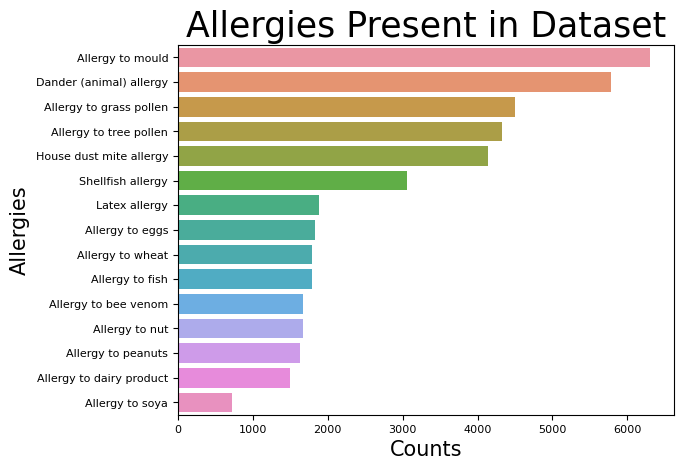

In [68]:
#Visualize allergy distribution
b = sns.countplot(data=df_allergies,y='DESCRIPTION',
                  order = df_allergies['DESCRIPTION'].value_counts().index)
b.axes.set_title("Allergies Present in Dataset",fontsize=25)
b.set_xlabel("Counts",fontsize=15)
b.set_ylabel("Allergies",fontsize=15)
b.tick_params(labelsize=8)
plt.show()

In [69]:
df_careplans

,PATIENT,CODE,DESCRIPTION,REASONCODE,REASONDESCRIPTION
0,55f07b08-3c77-42cc-8514-4c0a37c4039e,443402002,Lifestyle education regarding hypertension,59621000.0,Hypertension
1,55f07b08-3c77-42cc-8514-4c0a37c4039e,53950000,Respiratory therapy,10509002.0,Acute bronchitis (disorder)
2,55f07b08-3c77-42cc-8514-4c0a37c4039e,53950000,Respiratory therapy,10509002.0,Acute bronchitis (disorder)
3,55f07b08-3c77-42cc-8514-4c0a37c4039e,53950000,Respiratory therapy,10509002.0,Acute bronchitis (disorder)
4,55f07b08-3c77-42cc-8514-4c0a37c4039e,698360004,Diabetes self management plan,15777000.0,Prediabetes
...,...,...,...,...,...
1290305,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,53950000,Respiratory therapy,10509002.0,Acute bronchitis (disorder)
1290306,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,736252007,Cancer care plan,126906006.0,Neoplasm of prostate
1290307,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,385691007,Fracture care,58150001.0,Fracture of clavicle
1290308,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,736376001,Infectious disease care plan (record artifact),840544004.0,Suspected COVID-19


In [87]:
#Find unique patients and unique descriptions
print(df_careplans['PATIENT'].nunique())
print(df_careplans['DESCRIPTION'].nunique())
print(df_careplans['REASONDESCRIPTION'].nunique())

100809
37
74


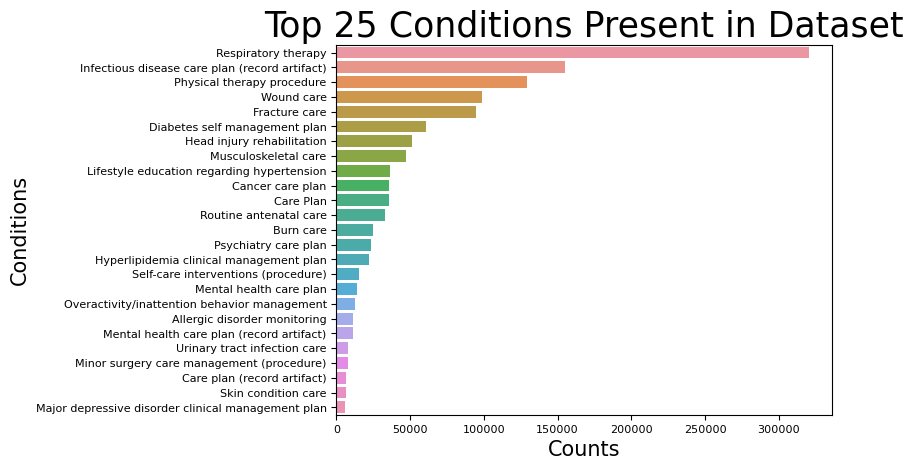

In [88]:
#Visualize conditions distribution
b = sns.countplot(data=df_careplans,y='DESCRIPTION',
                  order = df_careplans['DESCRIPTION'].value_counts().index[:25])
b.axes.set_title("Top 25 Conditions Present in Dataset",fontsize=25)
b.set_xlabel("Counts",fontsize=15)
b.set_ylabel("Conditions",fontsize=15)
b.tick_params(labelsize=8)
plt.show()

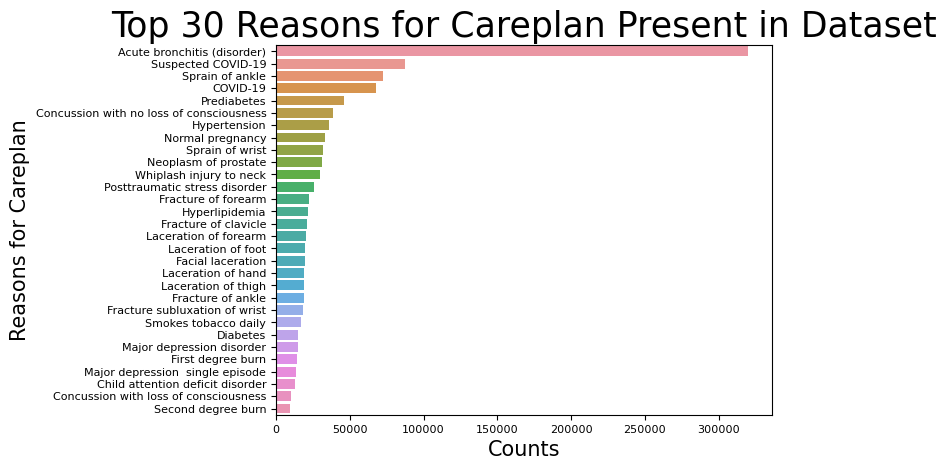

In [91]:
#Visualize conditions distribution
b = sns.countplot(data=df_careplans,y='REASONDESCRIPTION',
                  order = df_careplans['REASONDESCRIPTION'].value_counts().index[:30])
b.axes.set_title("Top 30 Reasons for Careplan Present in Dataset",fontsize=25)
b.set_xlabel("Counts",fontsize=15)
b.set_ylabel("Reasons for Careplan",fontsize=15)
b.tick_params(labelsize=8)
plt.show()

In [71]:
df_conditions

,PATIENT,CODE,DESCRIPTION
0,55f07b08-3c77-42cc-8514-4c0a37c4039e,195662009,Acute viral pharyngitis (disorder)
1,55f07b08-3c77-42cc-8514-4c0a37c4039e,65363002,Otitis media
2,55f07b08-3c77-42cc-8514-4c0a37c4039e,43878008,Streptococcal sore throat (disorder)
3,55f07b08-3c77-42cc-8514-4c0a37c4039e,195662009,Acute viral pharyngitis (disorder)
4,55f07b08-3c77-42cc-8514-4c0a37c4039e,195662009,Acute viral pharyngitis (disorder)
...,...,...,...
3672059,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,43724002,Chill (finding)
3672060,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,386661006,Fever (finding)
3672061,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,36955009,Loss of taste (finding)
3672062,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,840544004,Suspected COVID-19


In [72]:
#Find unique patients and unique descriptions
print(df_conditions['PATIENT'].nunique())
print(df_conditions['DESCRIPTION'].nunique())

100810
186


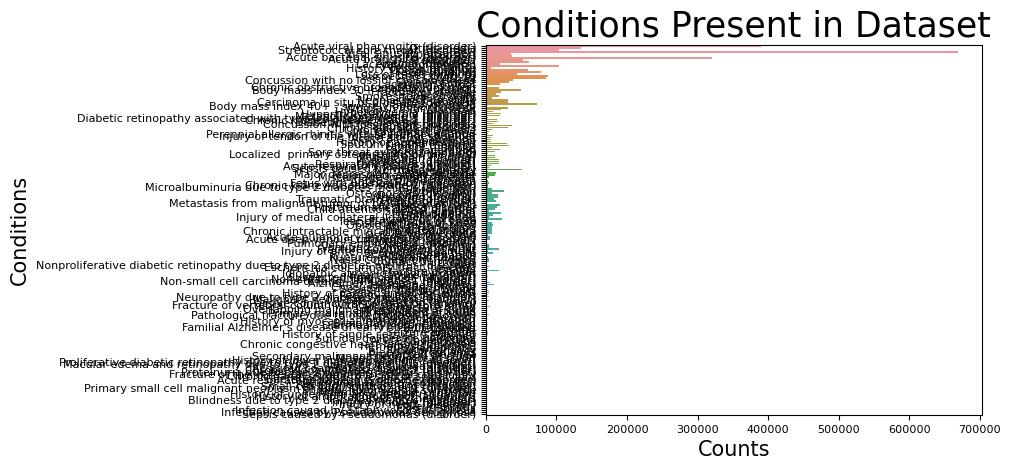

In [82]:
#Visualize conditions distribution
b = sns.countplot(data=df_conditions,y='DESCRIPTION')
b.axes.set_title("Conditions Present in Dataset",fontsize=25)
b.set_xlabel("Counts",fontsize=15)
b.set_ylabel("Conditions",fontsize=15)
b.tick_params(labelsize=8)
plt.show()

In [73]:
df_devices

,PATIENT,CODE,DESCRIPTION,UDI
0,5fce809a-f069-4ff3-a68c-76942da03278,706004007,Implantable cardiac pacemaker (physical object),(01)11599848534981(11)191026(17)441109(10)1530...
1,3da0bed0-f4ee-41d8-8cde-895a52bea26e,706004007,Implantable cardiac pacemaker (physical object),(01)71250478160806(11)960704(17)210719(10)3726...
2,fd8630cd-4ba5-4617-ad31-2cd5202ae186,72506001,Implantable defibrillator device (physical ob...,(01)12817452729914(11)111211(17)361225(10)2777...
3,993fb5d0-db7b-4b8e-8491-a8786f833e44,72506001,Implantable defibrillator device (physical ob...,(01)27866115517464(11)741115(17)991130(10)1007...
4,dbc68a08-5421-4421-a89b-bbc60e4e1269,72506001,Implantable defibrillator device (physical ob...,(01)33659393087823(11)170913(17)420928(10)6757...
...,...,...,...,...
9179,ab736ea2-d60a-474d-9e20-17ca72d3370d,706004007,Implantable cardiac pacemaker (physical object),(01)42292037075012(11)120524(17)370608(10)3610...
9180,cccddcc8-4bbf-4ea4-a466-271dcdf07246,72506001,Implantable defibrillator device (physical ob...,(01)36722796092159(11)730206(17)980221(10)1463...
9181,4bb5af1b-114e-4762-b21e-c2c162981b22,705643001,Coronary artery stent (physical object),(01)29899286445004(11)051218(17)310102(10)1385...
9182,3ae01835-3c24-48cb-84d6-0a5e130f1e7c,706004007,Implantable cardiac pacemaker (physical object),(01)20597026163127(11)130121(17)380205(10)3256...


In [74]:
#Find unique patients and unique descriptions
print(df_devices['PATIENT'].nunique())
print(df_devices['DESCRIPTION'].nunique())

8297
6


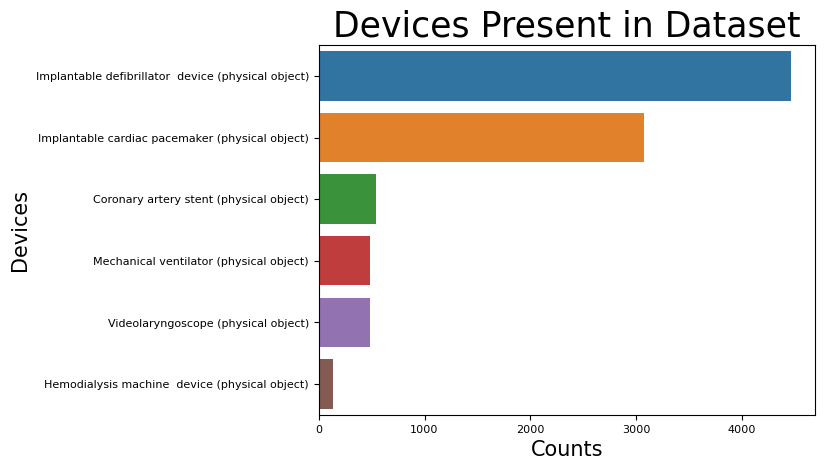

In [75]:
#Visualize conditions distribution
b = sns.countplot(data=df_devices,y='DESCRIPTION',
                  order = df_devices['DESCRIPTION'].value_counts().index)
b.axes.set_title("Devices Present in Dataset",fontsize=25)
b.set_xlabel("Counts",fontsize=15)
b.set_ylabel("Devices",fontsize=15)
b.tick_params(labelsize=8)
plt.show()

In [76]:
df_imaging_studies

,PATIENT,BODYSITE_CODE,BODYSITE_DESCRIPTION,MODALITY_CODE,MODALITY_DESCRIPTION,SOP_CODE,SOP_DESCRIPTION
0,9b95290a-6195-4a40-b5f7-096ae727e793,51299004,Clavicle,DX,Digital Radiography,1.2.840.10008.5.1.4.1.1.1.1,Digital X-Ray Image Storage
1,3589d3e0-1b87-4ef6-84f1-6be843786260,51185008,Chest,DX,Digital Radiography,1.2.840.10008.5.1.4.1.1.1.1,Digital X-Ray Image Storage
2,3589d3e0-1b87-4ef6-84f1-6be843786260,51299004,Clavicle,DX,Digital Radiography,1.2.840.10008.5.1.4.1.1.1.1,Digital X-Ray Image Storage
3,3589d3e0-1b87-4ef6-84f1-6be843786260,51299004,Clavicle,DX,Digital Radiography,1.2.840.10008.5.1.4.1.1.1.1,Digital X-Ray Image Storage
4,88dab48e-5ff5-42af-8eab-4a3c37574952,51185008,Chest,DX,Digital Radiography,1.2.840.10008.5.1.4.1.1.1.1,Digital X-Ray Image Storage
...,...,...,...,...,...,...,...
116470,7b56b1b8-1402-4210-a6f9-d03fb2226236,40983000,Arm,DX,Digital Radiography,1.2.840.10008.5.1.4.1.1.1.1,Digital X-Ray Image Storage
116471,7b56b1b8-1402-4210-a6f9-d03fb2226236,8205005,Wrist,DX,Digital Radiography,1.2.840.10008.5.1.4.1.1.1.1,Digital X-Ray Image Storage
116472,3495b961-c34d-453a-8304-992c8545c39c,40983000,Arm,DX,Digital Radiography,1.2.840.10008.5.1.4.1.1.1.1,Digital X-Ray Image Storage
116473,3495b961-c34d-453a-8304-992c8545c39c,51299004,Clavicle,DX,Digital Radiography,1.2.840.10008.5.1.4.1.1.1.1,Digital X-Ray Image Storage


In [77]:
#Find unique patients and unique descriptions
print(df_imaging_studies['PATIENT'].nunique())
print(df_imaging_studies['BODYSITE_DESCRIPTION'].nunique())
print(df_imaging_studies['MODALITY_DESCRIPTION'].nunique())
print(df_imaging_studies['SOP_DESCRIPTION'].nunique())

65762
12
4
5


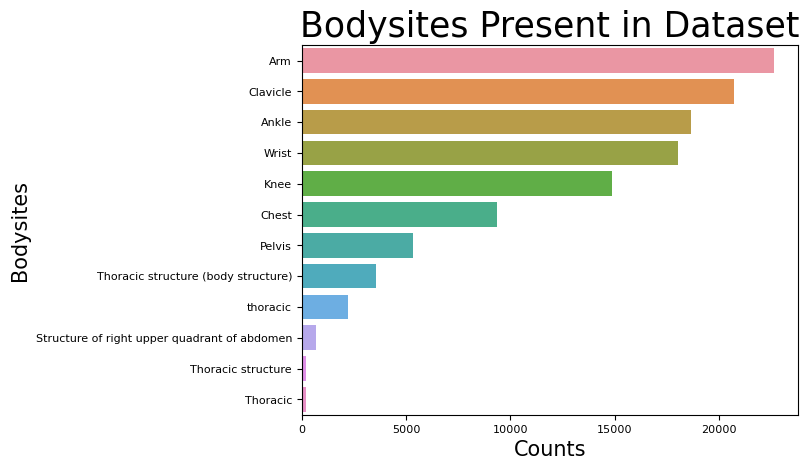

In [78]:
#Visualize conditions distribution 
b = sns.countplot(data=df_imaging_studies,y='BODYSITE_DESCRIPTION',
                  order = df_imaging_studies['BODYSITE_DESCRIPTION'].value_counts().index)
b.axes.set_title("Bodysites Present in Dataset",fontsize=25)
b.set_xlabel("Counts",fontsize=15)
b.set_ylabel("Bodysites",fontsize=15)
b.tick_params(labelsize=8)
plt.show()

In [79]:
df_immunizations

,PATIENT,CODE,DESCRIPTION
0,55f07b08-3c77-42cc-8514-4c0a37c4039e,10,IPV
1,55f07b08-3c77-42cc-8514-4c0a37c4039e,10,IPV
2,55f07b08-3c77-42cc-8514-4c0a37c4039e,10,IPV
3,55f07b08-3c77-42cc-8514-4c0a37c4039e,140,Influenza seasonal injectable preservative ...
4,55f07b08-3c77-42cc-8514-4c0a37c4039e,140,Influenza seasonal injectable preservative ...
...,...,...,...
6232920,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,140,Influenza seasonal injectable preservative ...
6232921,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,140,Influenza seasonal injectable preservative ...
6232922,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,140,Influenza seasonal injectable preservative ...
6232923,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,140,Influenza seasonal injectable preservative ...


In [80]:
#Find unique patients and unique descriptions
print(df_immunizations['PATIENT'].nunique())
print(df_immunizations['DESCRIPTION'].nunique())

100810
17


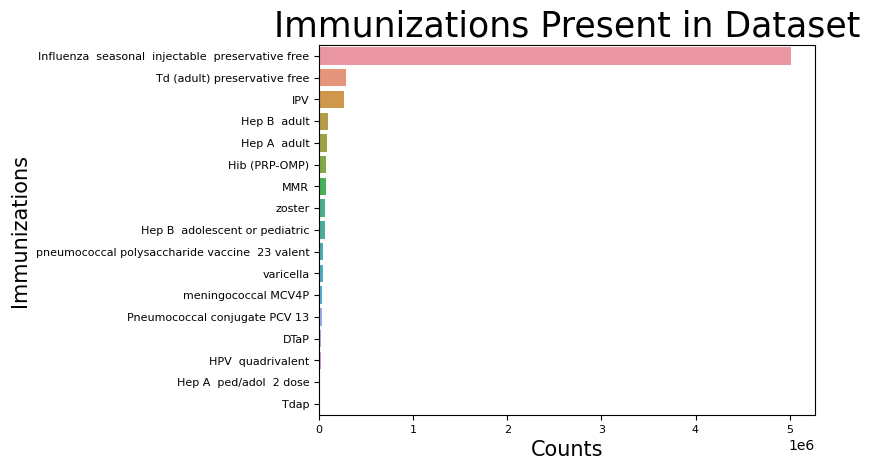

In [81]:
#Visualize conditions distribution 
b = sns.countplot(data=df_immunizations,y='DESCRIPTION',
                  order = df_immunizations['DESCRIPTION'].value_counts().index)
b.axes.set_title("Immunizations Present in Dataset",fontsize=25)
b.set_xlabel("Counts",fontsize=15)
b.set_ylabel("Immunizations",fontsize=15)
b.tick_params(labelsize=8)
plt.show()

In [82]:
df_medications

,PATIENT,CODE,DESCRIPTION,DISPENSES,TOTALCOST,REASONCODE,REASONDESCRIPTION
0,55f07b08-3c77-42cc-8514-4c0a37c4039e,834061,Penicillin V Potassium 250 MG Oral Tablet,1,15.37,195662009.0,Acute viral pharyngitis (disorder)
1,55f07b08-3c77-42cc-8514-4c0a37c4039e,313820,Acetaminophen 160 MG Chewable Tablet,1,2.31,NaN,NaN
2,55f07b08-3c77-42cc-8514-4c0a37c4039e,834061,Penicillin V Potassium 250 MG Oral Tablet,1,8.18,43878008.0,Streptococcal sore throat (disorder)
3,55f07b08-3c77-42cc-8514-4c0a37c4039e,1650142,Doxycycline Monohydrate 100 MG Oral Tablet,1,42.59,NaN,NaN
4,55f07b08-3c77-42cc-8514-4c0a37c4039e,313782,Acetaminophen 325 MG Oral Tablet,1,3.63,NaN,NaN
...,...,...,...,...,...,...,...
13330215,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,1860480,1 ML DOCEtaxel 20 MG/ML Injection,265,67575.00,NaN,NaN
13330216,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,752899,0.25 ML Leuprolide Acetate 30 MG/ML Prefilled ...,265,67575.00,NaN,NaN
13330217,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,834102,Penicillin V Potassium 500 MG Oral Tablet,1,26.41,43878008.0,Streptococcal sore throat (disorder)
13330218,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,1049221,Acetaminophen 325 MG / oxyCODONE Hydrochloride...,1,1382.63,NaN,NaN


In [83]:
df_medications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13330220 entries, 0 to 13330219
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   PATIENT            object 
 1   CODE               int64  
 2   DESCRIPTION        object 
 3   DISPENSES          int64  
 4   TOTALCOST          float64
 5   REASONCODE         float64
 6   REASONDESCRIPTION  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 711.9+ MB


In [84]:
#Find unique patients and unique descriptions
print(df_medications['PATIENT'].nunique())
print(df_medications['DESCRIPTION'].nunique())
print(df_medications['DISPENSES'].nunique())

100802
188
963


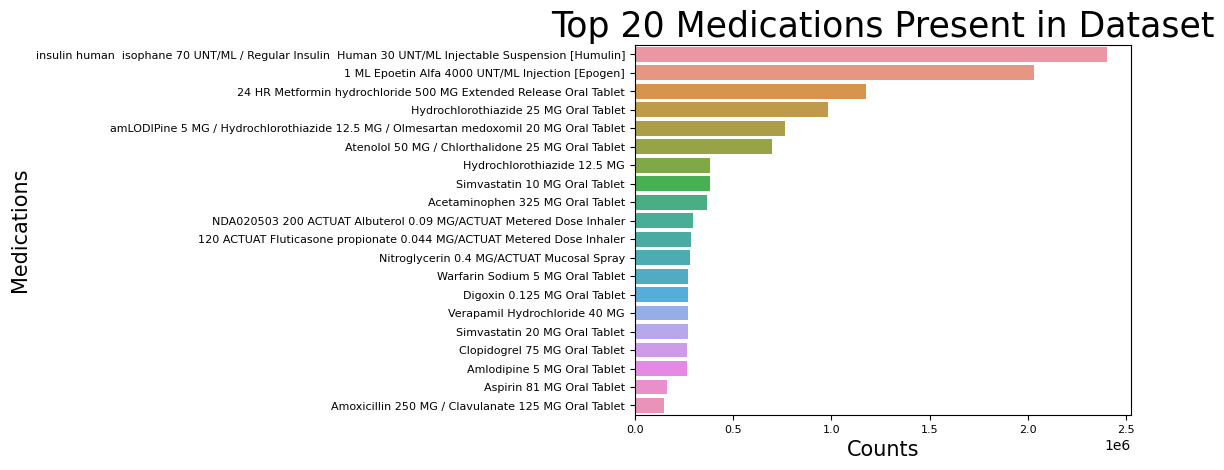

In [86]:
#Visualize conditions distribution 
b = sns.countplot(data=df_medications,y='DESCRIPTION',
                  order = df_medications['DESCRIPTION'].value_counts().index[:20])
b.axes.set_title("Top 20 Medications Present in Dataset",fontsize=25)
b.set_xlabel("Counts",fontsize=15)
b.set_ylabel("Medications",fontsize=15)
b.tick_params(labelsize=8)
plt.show()

In [126]:
df_observations

,PATIENT,CODE,DESCRIPTION,VALUE,UNITS
0,55f07b08-3c77-42cc-8514-4c0a37c4039e,8302-2,Body Height,49.3,cm
1,55f07b08-3c77-42cc-8514-4c0a37c4039e,72514-3,Pain severity - 0-10 verbal numeric rating [Sc...,0.0,{score}
2,55f07b08-3c77-42cc-8514-4c0a37c4039e,29463-7,Body Weight,3.1,kg
3,55f07b08-3c77-42cc-8514-4c0a37c4039e,77606-2,Weight-for-length Per age and sex,34.8,%
4,55f07b08-3c77-42cc-8514-4c0a37c4039e,9843-4,Head Occipital-frontal circumference,32.9,cm
...,...,...,...,...,...
208292922,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,QOLS,QOLS,0.9,{score}
208292923,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,QOLS,QOLS,0.9,{score}
208292924,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,QOLS,QOLS,0.9,{score}
208292925,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,QOLS,QOLS,0.9,{score}


In [127]:
#Find unique patients and unique descriptions
print(df_observations['PATIENT'].nunique())
print(df_observations['DESCRIPTION'].nunique())
print(df_observations['VALUE'].nunique())
print(df_observations['UNITS'].nunique())

100810
231
7019
44


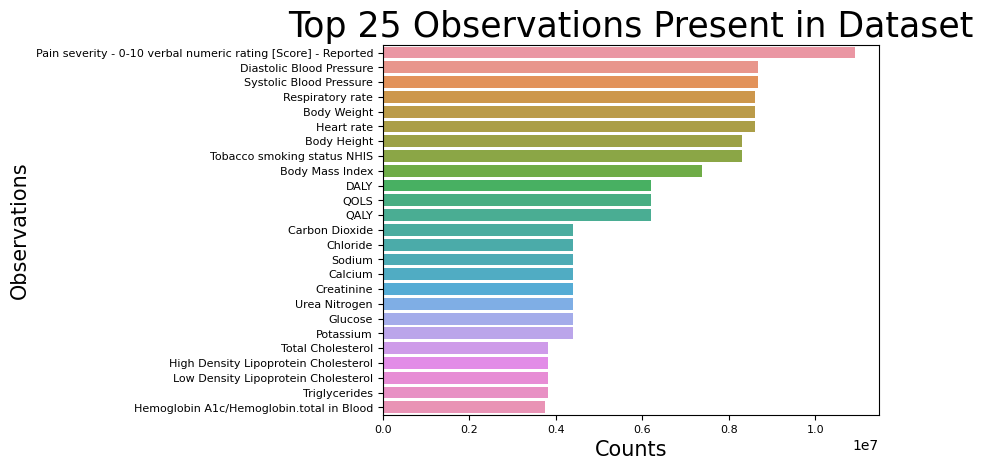

In [128]:
#Visualize conditions distribution 
b = sns.countplot(data=df_observations,y='DESCRIPTION',
                  order = df_observations['DESCRIPTION'].value_counts().index[:25])
b.axes.set_title("Top 25 Observations Present in Dataset",fontsize=25)
b.set_xlabel("Counts",fontsize=15)
b.set_ylabel("Observations",fontsize=15)
b.tick_params(labelsize=8)
plt.show()

In [138]:
df_organizations

,NAME,CITY,STATE,ZIP,LAT,LON,PHONE,REVENUE,UTILIZATION
0,SOUTHEAST ALABAMA MEDICAL CENTER,DOTHAN,AL,36301,31.233698,-85.406823,3347938701,132268.85999999676,1494.0
1,MARSHALL MEDICAL CENTER SOUTH,BOAZ,AL,35957,34.199020000000004,-86.155151,2565938310,129206.90999999674,1456.0
2,ELIZA COFFEE MEMORIAL HOSPITAL,FLORENCE,AL,35631,34.830349,-87.666096,2567688400,117083.72999999746,1323.0
3,MIZELL MEMORIAL HOSPITAL,OPP,AL,36467,34.261634,-86.568311,3344933541,53370.39000000022,604.0
4,ST VINCENT'S EAST,BIRMINGHAM,AL,35235,33.527444,-86.799047,2058383122,111671.93999999778,1257.0
...,...,...,...,...,...,...,...,...,...
113396,RAWLINGS URGENT CARE,RAWLINS,WY,82301,41.7863012,-107.263400,307-324-6002,218000.0,1744.0
113397,SOUTH SHERIDAN MEDICAL CENTER - URGENT CARE CL...,SHERIDAN,WY,82801,44.7777281,-106.940104,307-673-5586,102875.0,823.0
113398,COAL COUNTRY CLINIC,GILLETTE,WY,82716,44.2913311,-105.520597,307-682-3004,83500.0,668.0
113399,INSTACARE OF CASPER,CASPER,WY,82601,42.8355562,-106.336698,307-237-2273,84125.0,673.0


In [ ]:
#list of dataframes for batch processing
#data_frames = [
#    df_allergies, df_careplans, df_conditions, df_devices, df_encounters,df_imaging_studies,
#    df_immunizations,df_medications, df_observations, df_organizations, df_patients, df_payers, df_payer_transitions,
#    df_procedures, df_providers, df_supplies 
#]

In [ ]:
#Need to rename the columns since there are quite a few duplicate names that are unique to each .csv
#In particular CODE, DESCRIPTION, ENCOUNTER, START, STOP
df.rename(columns={"A": "a", "B": "c"})

In [129]:
rs_df_list[2]

,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION
0,"[1957-09-20, 1957-12-17, 1961-07-16, 1962-01-2...","[1957-10-01, 1958-01-28, 1961-07-24, 1962-02-0...",331bab68-dd6e-4e20-b8dd-4edb0cd86457,"[6f777c09-97ea-4415-b745-76ab5a7568ac, 3fc5380...","[195662009, 65363002, 43878008, 195662009, 195...","[Acute viral pharyngitis (disorder), Otitis me..."
1,"[1957-09-20, 1957-12-17, 1961-07-16, 1962-01-2...","[1957-10-01, 1958-01-28, 1961-07-24, 1962-02-0...",b6d8ae21-da36-4221-afce-6f0d0ba7c801,"[6f777c09-97ea-4415-b745-76ab5a7568ac, 3fc5380...","[195662009, 65363002, 43878008, 195662009, 195...","[Acute viral pharyngitis (disorder), Otitis me..."
2,"[1957-09-20, 1957-12-17, 1961-07-16, 1962-01-2...","[1957-10-01, 1958-01-28, 1961-07-24, 1962-02-0...",42529e44-0117-46ea-b795-74d37aa93783,"[6f777c09-97ea-4415-b745-76ab5a7568ac, 3fc5380...","[195662009, 65363002, 43878008, 195662009, 195...","[Acute viral pharyngitis (disorder), Otitis me..."


In [72]:
condensed_allergy_df,index_list  = make_patient_df(10, df_allergies, init_rand=True)
condensed_allergy_df

These are the indices for the patient IDs used to generate the dataframe below. 
 [7288, 8413, 3434, 3893, 5010, 2709, 6826, 8505, 1083, 7337]


,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION
0,"[1976-05-28, 1976-05-28, 1976-05-28, 1976-05-2...","[1993-01-25, 1993-07-07, 1993-07-07, 1993-07-0...",bdcc1813-e534-4ad0-a287-5d02029c947f,"[04d56a05-5756-459f-bb6a-b465bccc6e94, 04d56a0...","[300916003, 419474003, 232347008, 419263009, 3...","[Latex allergy, Allergy to mould, Dander (anim..."
1,"[1983-12-17, 1983-12-17, 1983-12-17, 1983-12-1...","[1999-01-20, 1999-01-20, 1999-01-20, nan, 1999...",1c21c496-75be-44e9-a754-9412322e19d1,"[a79382ed-5ae5-4a6a-ab77-7a3aeef1a5e7, a79382e...","[419474003, 232350006, 232347008, 418689008, 4...","[Allergy to mould, House dust mite allergy, Da..."
2,"[1952-01-12, 1952-01-12, 1952-01-12, 1952-01-1...","[1968-02-07, nan, 1993-07-08, 1993-07-08, 1993...",3e155d5e-cb9f-4ee2-8121-0c9dd4fffaf7,"[fc0b7ad8-5496-4ef4-9c6f-5af1e0b32a97, fc0b7ad...","[300916003, 424213003, 419474003, 232350006, 2...","[Latex allergy, Allergy to bee venom, Allergy ..."
3,"[1959-10-03, 1959-10-03, 1959-10-03, 1959-10-0...","[1977-03-20, nan, 1993-07-06, 1993-07-06, nan,...",6aa9b177-2a56-478d-a3cd-9ed5a13eee9c,"[c72ab227-dac9-40c3-87d8-396be9950101, c72ab22...","[300916003, 424213003, 419474003, 232350006, 2...","[Latex allergy, Allergy to bee venom, Allergy ..."
4,"[1991-08-31, 1991-08-31]","[nan, nan]",0e4f152f-0aa7-4aa9-bb3a-062b760f7bb0,"[56bc5a8a-51eb-44fc-a888-ba819483eb96, 56bc5a8...","[232347008, 417532002]","[Dander (animal) allergy, Allergy to fish]"
5,"[1957-02-02, 1957-02-02]","[nan, nan]",1026f6de-2522-4cc2-b239-edbe96ec9982,"[9e31c1d3-145d-4ddf-9b81-7b9f8f0d2f8c, 9e31c1d...","[419474003, 91935009]","[Allergy to mould, Allergy to peanuts]"
6,"[1959-01-31, 1959-01-31, 1959-01-31, 1959-01-3...","[nan, nan, nan, nan, nan, nan]",65547d69-035d-45c3-8826-5291ebb61198,"[20c4bc2e-0046-49dc-9ed3-c9de17ace0e5, 20c4bc2...","[300916003, 419474003, 232350006, 232347008, 4...","[Latex allergy, Allergy to mould, House dust m..."
7,"[1950-06-04, 1950-06-04, 1950-06-04, 1950-06-0...","[nan, nan, nan, nan, nan, nan, nan]",d6a5fd92-acb6-4a11-9872-6ef3d2a96f64,"[f52461d0-2a09-4c67-ae9a-deaff530c1c6, f52461d...","[424213003, 419474003, 232350006, 232347008, 4...","[Allergy to bee venom, Allergy to mould, House..."
8,"[1984-06-02, 1984-06-02, 1984-06-02, 1984-06-0...","[2000-06-25, nan, nan, 1999-08-01, 1999-08-01,...",24323ab9-008b-4fc1-a789-ecf83f7679f3,"[63c68862-3087-4a24-adac-66239094e75d, 63c6886...","[300916003, 424213003, 419474003, 232347008, 4...","[Latex allergy, Allergy to bee venom, Allergy ..."
9,[1933-11-30],[1951-10-16],95099a3b-4326-427a-9adf-c8417bd130df,[564f8602-ebd4-4e3a-b313-a532cb3c42b1],[91930004],[Allergy to eggs]


In [39]:
print(df_careplans['PATIENT'].nunique())
print(df_careplans['DESCRIPTION'].nunique())
print(df_careplans['REASONDESCRIPTION'].nunique())

100809
37
74


In [64]:
df_conditions

,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION
0,1957-09-20,1957-10-01,55f07b08-3c77-42cc-8514-4c0a37c4039e,6f777c09-97ea-4415-b745-76ab5a7568ac,195662009,Acute viral pharyngitis (disorder)
1,1957-12-17,1958-01-28,55f07b08-3c77-42cc-8514-4c0a37c4039e,3fc5380a-53dc-4c46-8e0c-6014a3a279cd,65363002,Otitis media
2,1961-07-16,1961-07-24,55f07b08-3c77-42cc-8514-4c0a37c4039e,f57946ec-edf4-466b-9657-729e57920f17,43878008,Streptococcal sore throat (disorder)
3,1962-01-23,1962-02-03,55f07b08-3c77-42cc-8514-4c0a37c4039e,71371290-9340-4c82-b58f-f10433f5cb94,195662009,Acute viral pharyngitis (disorder)
4,1964-09-22,1964-10-05,55f07b08-3c77-42cc-8514-4c0a37c4039e,f707e04f-83f5-4251-8d16-7c551b3e8468,195662009,Acute viral pharyngitis (disorder)
...,...,...,...,...,...,...
3672059,2020-03-11,2020-03-25,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,46911c7e-045a-42b4-ae9f-645377e60864,43724002,Chill (finding)
3672060,2020-03-11,2020-03-25,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,46911c7e-045a-42b4-ae9f-645377e60864,386661006,Fever (finding)
3672061,2020-03-11,2020-03-25,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,46911c7e-045a-42b4-ae9f-645377e60864,36955009,Loss of taste (finding)
3672062,2020-03-11,2020-03-11,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,46911c7e-045a-42b4-ae9f-645377e60864,840544004,Suspected COVID-19


In [65]:
df_devices

,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION,UDI
0,2019-11-16T21:13:01Z,NaN,5fce809a-f069-4ff3-a68c-76942da03278,9328ed28-eb36-44c0-a1ff-c38b433dec69,706004007,Implantable cardiac pacemaker (physical object),(01)11599848534981(11)191026(17)441109(10)1530...
1,1996-07-25T21:02:59Z,NaN,3da0bed0-f4ee-41d8-8cde-895a52bea26e,92352b1c-b755-4e51-ae99-9ecbc9b1814c,706004007,Implantable cardiac pacemaker (physical object),(01)71250478160806(11)960704(17)210719(10)3726...
2,2012-01-01T21:07:49Z,NaN,fd8630cd-4ba5-4617-ad31-2cd5202ae186,4d03aeab-f673-485b-91a4-31f8af7ef7ae,72506001,Implantable defibrillator device (physical ob...,(01)12817452729914(11)111211(17)361225(10)2777...
3,1974-12-06T18:30:47Z,NaN,993fb5d0-db7b-4b8e-8491-a8786f833e44,38637d2d-4a51-4ee5-b176-f65a148f0423,72506001,Implantable defibrillator device (physical ob...,(01)27866115517464(11)741115(17)991130(10)1007...
4,2017-10-04T16:09:05Z,NaN,dbc68a08-5421-4421-a89b-bbc60e4e1269,aead11a7-9135-4869-a7e0-ef6f4e88d26b,72506001,Implantable defibrillator device (physical ob...,(01)33659393087823(11)170913(17)420928(10)6757...
...,...,...,...,...,...,...,...
9179,2012-06-14T18:56:52Z,NaN,ab736ea2-d60a-474d-9e20-17ca72d3370d,bbb3bcef-4869-497d-99d7-603acd2fb79d,706004007,Implantable cardiac pacemaker (physical object),(01)42292037075012(11)120524(17)370608(10)3610...
9180,1973-02-28T00:02:48Z,NaN,cccddcc8-4bbf-4ea4-a466-271dcdf07246,b1762414-79d8-444b-8462-c7ef8dc60ea5,72506001,Implantable defibrillator device (physical ob...,(01)36722796092159(11)730206(17)980221(10)1463...
9181,2006-01-08T10:25:12Z,NaN,4bb5af1b-114e-4762-b21e-c2c162981b22,f7b4ee41-6042-4172-a0f4-259ca388b55e,705643001,Coronary artery stent (physical object),(01)29899286445004(11)051218(17)310102(10)1385...
9182,2013-02-11T08:32:17Z,NaN,3ae01835-3c24-48cb-84d6-0a5e130f1e7c,414030cd-670b-4082-8498-6b470120b3f3,706004007,Implantable cardiac pacemaker (physical object),(01)20597026163127(11)130121(17)380205(10)3256...


In [66]:
df_encounters

,Id,START,STOP,PATIENT,ORGANIZATION,PROVIDER,PAYER,ENCOUNTERCLASS,CODE,DESCRIPTION,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,PAYER_COVERAGE,REASONCODE,REASONDESCRIPTION
0,c4a23506-81ac-454d-93a7-e41eee8ee92b,1957-05-21T20:39:45Z,1957-05-21T20:54:45Z,55f07b08-3c77-42cc-8514-4c0a37c4039e,dd5334a7-972e-30b1-b537-7767769efcef,cae319fe-9fcc-394e-80e5-bc9a8a7f6c54,d47b3510-2895-3b70-9897-342d681c769d,wellness,410620009,Well child visit (procedure),89.01,89.01,9.01,NaN,NaN
1,ef7eb530-8aa2-4b7a-8a20-51e0fe94ce98,1957-06-25T20:39:45Z,1957-06-25T21:09:45Z,55f07b08-3c77-42cc-8514-4c0a37c4039e,dd5334a7-972e-30b1-b537-7767769efcef,cae319fe-9fcc-394e-80e5-bc9a8a7f6c54,d47b3510-2895-3b70-9897-342d681c769d,wellness,410620009,Well child visit (procedure),89.01,89.01,9.01,NaN,NaN
2,edc1b81b-6c66-45ee-ace6-893f4b7f15ee,1957-08-27T20:39:45Z,1957-08-27T21:09:45Z,55f07b08-3c77-42cc-8514-4c0a37c4039e,dd5334a7-972e-30b1-b537-7767769efcef,cae319fe-9fcc-394e-80e5-bc9a8a7f6c54,d47b3510-2895-3b70-9897-342d681c769d,wellness,410620009,Well child visit (procedure),89.01,89.01,9.01,NaN,NaN
3,6f777c09-97ea-4415-b745-76ab5a7568ac,1957-09-20T20:39:45Z,1957-09-20T20:54:45Z,55f07b08-3c77-42cc-8514-4c0a37c4039e,1ef2c91d-c01a-396c-80a8-4c1982295946,0c54d0ea-ffe7-3347-9d30-860164fa689f,d47b3510-2895-3b70-9897-342d681c769d,ambulatory,185345009,Encounter for symptom,89.01,89.01,9.01,195662009.0,Acute viral pharyngitis (disorder)
4,94163934-71eb-4d94-98f5-a576453688c5,1957-10-29T20:39:45Z,1957-10-29T20:54:45Z,55f07b08-3c77-42cc-8514-4c0a37c4039e,dd5334a7-972e-30b1-b537-7767769efcef,cae319fe-9fcc-394e-80e5-bc9a8a7f6c54,d47b3510-2895-3b70-9897-342d681c769d,wellness,410620009,Well child visit (procedure),89.01,89.01,9.01,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20882420,3df10d41-9c85-4290-9bbb-7db2f0ae4bb5,2017-08-07T02:26:03Z,2017-08-07T02:56:03Z,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,4b3fa477-bc25-370b-b252-92cdb6dfad1e,ed70ec29-f2a6-3c2a-a5c5-8403c48254d2,7caa7254-5050-3b5e-9eae-bd5ea30e809c,wellness,162673000,General examination of patient (procedure),125.00,125.00,125.00,NaN,NaN
20882421,f36bf471-2904-4cbb-87fd-7c8ef79f225a,2018-08-13T02:26:03Z,2018-08-13T02:56:03Z,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,4b3fa477-bc25-370b-b252-92cdb6dfad1e,ed70ec29-f2a6-3c2a-a5c5-8403c48254d2,7caa7254-5050-3b5e-9eae-bd5ea30e809c,wellness,162673000,General examination of patient (procedure),125.00,125.00,125.00,NaN,NaN
20882422,4f237f52-768d-4ffa-a7e0-8bdd7056bd20,2019-08-19T02:26:03Z,2019-08-19T02:56:03Z,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,4b3fa477-bc25-370b-b252-92cdb6dfad1e,ed70ec29-f2a6-3c2a-a5c5-8403c48254d2,7caa7254-5050-3b5e-9eae-bd5ea30e809c,wellness,162673000,General examination of patient (procedure),125.00,125.00,125.00,NaN,NaN
20882423,46911c7e-045a-42b4-ae9f-645377e60864,2020-03-12T02:26:03Z,2020-03-12T03:52:03Z,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,4b3fa477-bc25-370b-b252-92cdb6dfad1e,ed70ec29-f2a6-3c2a-a5c5-8403c48254d2,7caa7254-5050-3b5e-9eae-bd5ea30e809c,ambulatory,185345009,Encounter for symptom (procedure),125.00,125.00,85.00,NaN,NaN


In [122]:
# compile the list of dataframes I want to merge
#data_frames = [
#    df_allergies, df_careplans, df_conditions, df_devices, df_encounters,df_imaging_studies,
#    df_immunizations,df_medications, df_observations, df_organizations, df_patients, df_payers, df_payer_transitions,
#    df_procedures, df_providers, df_supplies]

In [26]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual,interactive

#!jupyter nbextension enable --py --sys-prefix widgetsnbextension

In [115]:
cond = 'allergy'#input('Enter the disease condition to find clinical trials: ')
a = 'https://clinicaltrials.gov/api/query/study_fields?expr='
b = '&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CLeadSponsorName%2CEligibilityCriteria'
c = '&min_rnk=1&max_rnk=1000&fmt=csv'
q=(a + cond + b + c)
print(q)
qtrials = pd.read_csv(q,skiprows=10)
qtrials

https://clinicaltrials.gov/api/query/study_fields?expr=allergy&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CLeadSponsorName%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv


,Rank,NCTId,BriefTitle,Condition,OverallStatus,LeadSponsorName,EligibilityCriteria
0,1,NCT04827602,Drug Allergy Labels After Drug Allergy Investi...,Drug Hypersensitivity,Completed,"University Hospital, Gentofte, Copenhagen",Inclusion Criteria:||Penicillin allergy tested...
1,2,NCT03826953,Allergy UK Research and Development Nurse Project,Allergy,Unknown status,University of Edinburgh,"Inclusion Criteria:||All children, young peopl..."
2,3,NCT05561777,Penicillin Allergy Risk-Stratification and Del...,Antibiotic Allergy,Recruiting,Vanderbilt University Medical Center,Inclusion Criteria:||Pediatric Hospital Medici...
3,4,NCT01914978,Evaluating the Effectiveness of a Handbook for...,"Hypersensitivity, Food",Completed,Boston Children's Hospital,Inclusion Criteria:||Parents of children ages ...
4,5,NCT03581604,De-labeling of Patients With False Diagnosis o...,Allergy Drug,Recruiting,Oslo University Hospital,Inclusion Criteria:||Adult patients who are re...
...,...,...,...,...,...,...,...
995,996,NCT03703791,"Real World, Open Label, QOL Assessment of Pean...",Peanut Allergy,Terminated,"Aimmune Therapeutics, Inc.",Key Inclusion Criteria:||Age 4 through 17 year...
996,997,NCT00517062,Low Dose Growth Hormone (GH) on Insulin Sensit...,Growth Hormone Deficiency,Completed,Oregon Health and Science University,Inclusion Criteria:||Age range 18 to 75 years|...
997,998,NCT04112706,Efficacy of CPP-ACP on Bleaching Related Sensi...,Teeth Sensitivity|Tooth Discoloration,Completed,University of New England,Inclusion Criteria:||Male or female patients b...
998,999,NCT04904861,Group Videoconferencing Intervention to Improv...,Parent-Child Relations|Parenting,"Active, not recruiting",Pontificia Universidad Catolica de Chile,Inclusion Criteria:||Mother of a baby between ...


In [119]:
qtrials['EligibilityCriteria'][996]

'Inclusion Criteria:||Age range 18 to 75 years|BMI should not exceed 40 kg/m2|Confirmed GH deficient with at least one provocative test, e.g. insulin tolerance test and/ or GHRH/arginine|Not received any GH therapy within last 6 months|On a stable standardized hydrocortisone replacement dose regimen (twice a day at 8 AM and 4 PM),|If any other pituitary hormone deficiencies are present, patient must be on optimal pituitary hormone replacement therapy, e.g. Thyroxine, testosterone and oestrogen replacement|Normal renal and hepatic function|Prepared to self-inject||Exclusion Criteria:||Untreated or subclinically hypo/hyperthyroid|Untreated or subclinically treated hypocortisolism|Type 1 or 2 diabetes mellitus|Subjects with evidence of nephropathy from any cause|Subjects with evidence of retinopathy from any cause|Any other medical illnesses that may affect the interpretation of the results|Pregnant|Emotional/social instability likely to prejudice study completion|Previous history of know

In [116]:
#@interact
#def show_recruiting_studies(column='OverallStatus', x=['Recruiting','Completed']):
#    return qtrials.loc[qtrials[column] == x]

In [39]:
qtrials.loc[qtrials['OverallStatus'] == 'Recruiting']

,Rank,NCTId,BriefTitle,Condition,OverallStatus,LeadSponsorName
2,3,NCT05561777,Penicillin Allergy Risk-Stratification and Del...,Antibiotic Allergy,Recruiting,Vanderbilt University Medical Center
4,5,NCT03581604,De-labeling of Patients With False Diagnosis o...,Allergy Drug,Recruiting,Oslo University Hospital
5,6,NCT04400214,The Food Allergy Superheroes Training (FAST) P...,"Allergy;Food|Adherence, Treatment|Child, Only",Recruiting,Kent State University
14,15,NCT05671471,Accidental Reactions in Peanut/Tree Nut Allerg...,Peanut and Tree Nut Allergy,Recruiting,"University Hospital, Lille"
20,21,NCT04462978,Non-Immunoglobulin E-mediated Food Allergies i...,Non IgE Mediated Food Allergy|Food Protein-Ind...,Recruiting,Federico II University
...,...,...,...,...,...,...
974,975,NCT03696433,Visualizing Vascular Mechanisms of Salt Sensit...,Obesity|Cardiovascular Risk Factor|Salt; Excess,Recruiting,Vanderbilt University Medical Center
976,977,NCT05567263,Post-operative Sensitivity of a Self-adhesive ...,"Dental Restorations, Permanent",Recruiting,King Abdullah University Hospital
981,982,NCT04422184,Comparative Clinical Evaluation of Three Diffe...,Dentin Hypersensitivity|Periodontal Diseases,Recruiting,University of Sao Paulo
983,984,NCT05059236,A Study to Learn How Well Darolutamide Adminis...,Metastatic Hormone-sensitive Prostate Cancer,Recruiting,Bayer


In [124]:
def restructure_dfs(ref_df,source_df,nPatients):
    """
    This function combines the observations for a patient in the Synthetic Veteran Suicide Dataset into a 
    single row in a new dataframe. Doing this should help with the NLP processing later.
    
    Parameters
    ----------
    nPatients : int,  How many patients to process?
    ref_df    : df,   Dataframe containing restructured patient data (should be the first dataframe that was 
                      restructured)
    source_df : df,   Dataframe that contains information to be restructured
    ----------
    """
    # Create empty patient dataframe
    columns = source_df.columns
    temp_df = pd.DataFrame(index=np.arange(nPatients),columns=columns)    
    
    for i in tqdm(range(ref_df.shape[0])):
        patient = ref_df['PATIENT'][i] #Patient ID    
        #dummy_df   = source_df[source_df['PATIENT'] == patient]
        
        #Programatically populate the dataframe by first making lists out of the columns and then inserting
        #these lists into cells in the resulting dataframe
        for k,col in enumerate(columns):
            if col == 'PATIENT':
                temp_df.at[i, 'PATIENT'] = patient    
            else:
                temp_df.at[i, col] = source_df[col].tolist()
                
    return temp_df

def make_patient_df(nPatients,df,df_list,init_rand=False):
    """
    This function combines the observations for a patient in the Synthetic Veteran Suicide Dataset into a 
    single row in a new dataframe. Doing this should help with the NLP processing later.
    
    Parameters
    ----------
    nPatients : int,  How many patients to process?
    df        : df,   Dataframe containing patient data
    df_list   : list, list of all dataframes in dataset
    init_rand : bool, Use random values to choose patients? Defaults to False so only first 10 patients are selected
    ----------
    """
    #Determine number of unique patients in dataframe
    unique_patients = df['PATIENT'].nunique()
    
    #Initialize iterators and patient index
    i = 0; j = random.randrange(unique_patients)
    
    #Initialize index array
    index_list = []
    
    # Create empty patient dataframe
    columns = df.columns
    new_df  = pd.DataFrame(index=np.arange(nPatients),columns=columns)
    
    #Make list of restructured dataframes
    rs_df_list = []
    
    for i in range(nPatients):
        
        #Select a random patient from the existing dataframe (random sample)
        if init_rand == True:
            j = random.randrange(unique_patients)                
        else:
            j = i 
        
        #Check that patient id has not already been added
        if j not in index_list:
            index_list.append(j)
        else:
            while j in index_list:
                j = random.randrange(unique_patients) 
            index_list.append(j)
        
        #Subset the dataframe so as to only show the results associated with a given patient
        patient    = df['PATIENT'][j] #Patient ID
        dummy_df   = df[df['PATIENT'] == patient]
        
        #Programatically populate the dataframe by first making lists out of the columns and then inserting
        #these lists into cells in the resulting dataframe
        for k,col in enumerate(cols):
            if col == 'PATIENT':
                new_df.at[i, 'PATIENT'] = patient    
            else:
                new_df.at[i, col] = dummy_df[col].tolist()
   
    #Append the restructured dataframe to the list of dfs
    rs_df_list.append(new_df)
    
    #Reprocess the remaining dataframes and add them to the list
    for m,cdf in enumerate(df_list[1:]):
        temp_df = restructure_dfs(new_df,cdf,nPatients)
        rs_df_list.append(temp_df)
        if m == 7:
            break
            
    print('These are the indices for the patient IDs used to generate the dataframe below. \n',index_list)

    return new_df,index_list,rs_df_list  

#condensed_allergy_df,index_list,rs_df_list  = make_patient_df(3, df_allergies,data_frames, init_rand=True)

In [140]:
# compile the list of dataframes I want to merge
data_frames = [
    df_allergies, df_careplans, df_conditions, df_devices,df_imaging_studies,
    df_immunizations,df_medications, df_observations, df_patients,
    df_procedures, df_supplies
]

In [ ]:
condensed_allergy_df,index_list,rs_df_list  = make_patient_df(1, df_allergies,data_frames, init_rand=True)

## NLP
I'll start by using a pretrained Entity Detection Model from sciSpacy 

In [141]:
#Download the ED model
nlp = spacy.load("en_core_sci_md")

In [142]:
#Enter a sample medical description
doc = nlp("An allograft was used to recreate the coracoacromial ligaments and then \
          secured to decorticate with a bioabsorbable tenodesis screw and then to the clavicle.")

In [143]:
#Enter string formatters for nice printout
fmt_str = "{:<15}| {:<6}| {:<7}| {:<8}"
print(fmt_str.format("token", "pos", "label", "parent"))

#Use a pipeline to tokenize and then carry out POS tagging, synytactic dependencies, and specify the 
#type of entity a token is as well as to what part of the text they are related to
for token in doc:
    print(fmt_str.format(token.text, token.pos_, token.ent_type_, token.head.text))

token          | pos   | label  | parent  
An             | DET   |        | allograft
allograft      | NOUN  | ENTITY | used    
was            | AUX   |        | used    
used           | VERB  |        | used    
to             | PART  |        | recreate
recreate       | VERB  | ENTITY | used    
the            | DET   |        | ligaments
coracoacromial | ADJ   | ENTITY | ligaments
ligaments      | NOUN  | ENTITY | recreate
and            | CCONJ |        | recreate
then           | ADV   |        | secured 
               | SPACE |        | secured 
secured        | VERB  |        | used    
to             | PART  |        | decorticate
decorticate    | NOUN  | ENTITY | secured 
with           | ADP   |        | screw   
a              | DET   |        | screw   
bioabsorbable  | ADJ   | ENTITY | tenodesis
tenodesis      | NOUN  | ENTITY | screw   
screw          | NOUN  | ENTITY | secured 
and            | CCONJ |        | secured 
then           | ADV   |        | secured 
to  

In [144]:
#Download the NER model
nlp = spacy.load("en_ner_bionlp13cg_md")

In [145]:
#Enter a sample medical description
doc = nlp("An allograft was used to recreate the coracoacromial ligaments and then \
          secured to decorticate with a bioabsorbable tenodesis screw and then to the clavicle.")

#Enter string formatters for nice printout
fmt_str = "{:<15}| {:<6}| {:<7}| {:<8}"
print(fmt_str.format("token", "pos", "label", "parent"))

#Use a pipeline to tokenize and then carry out POS tagging, synytactic dependencies, and specify the 
#type of entity a token is as well as to what part of the text they are related to
for token in doc:
    print(fmt_str.format(token.text, token.pos_, token.ent_type_, token.head.text))

token          | pos   | label  | parent  
An             | DET   |        | allograft
allograft      | NOUN  | CANCER | used    
was            | AUX   |        | used    
used           | VERB  |        | used    
to             | PART  |        | recreate
recreate       | VERB  |        | used    
the            | DET   |        | ligaments
coracoacromial | ADJ   | PATHOLOGICAL_FORMATION| ligaments
ligaments      | NOUN  | PATHOLOGICAL_FORMATION| recreate
and            | CCONJ |        | recreate
then           | ADV   |        | secured 
               | SPACE |        | secured 
secured        | VERB  |        | used    
to             | PART  |        | decorticate
decorticate    | NOUN  |        | secured 
with           | ADP   |        | screw   
a              | DET   |        | screw   
bioabsorbable  | ADJ   |        | tenodesis
tenodesis      | NOUN  |        | screw   
screw          | NOUN  |        | secured 
and            | CCONJ |        | secured 
then           | 

In [155]:
import medspacy
from medspacy.ner import TargetRule
from medspacy.visualization import visualize_ent

In [163]:
nlp = medspacy.load()
print(nlp.pipe_names)

['medspacy_pyrush', 'medspacy_target_matcher', 'medspacy_context']


In [164]:
text = """
Past Medical History:
1. Atrial fibrillation
2. Type II Diabetes Mellitus

Assessment and Plan:
There is no evidence of pneumonia. Continue warfarin for Afib. Follow up for management of type 2 DM.
"""

In [165]:
# Add rules for target concept extraction
target_matcher = nlp.get_pipe("medspacy_target_matcher")

In [166]:
target_rules = [
    TargetRule("atrial fibrillation", "PROBLEM"),
    TargetRule("atrial fibrillation", "PROBLEM", pattern=[{"LOWER": "afib"}]),
    TargetRule("pneumonia", "PROBLEM"),
    TargetRule("Type II Diabetes Mellitus", "PROBLEM", 
              pattern=[
                  {"LOWER": "type"},
                  {"LOWER": {"IN": ["2", "ii", "two"]}},
                  {"LOWER": {"IN": ["dm", "diabetes"]}},
                  {"LOWER": "mellitus", "OP": "?"}
              ]),
    TargetRule("warfarin", "MEDICATION")
]
target_matcher.add(target_rules)

In [169]:
doc = nlp(text)
visualize_ent(doc)

In [149]:
#Enter a sample medical description
doc = nlp("An allograft was used to recreate the coracoacromial ligaments and then \
          secured to decorticate with a bioabsorbable tenodesis screw and then to the clavicle.")

#Enter string formatters for nice printout
fmt_str = "{:<15}| {:<6}| {:<7}| {:<8}"
print(fmt_str.format("token", "pos", "label", "parent"))

#Use a pipeline to tokenize and then carry out POS tagging, synytactic dependencies, and specify the 
#type of entity a token is as well as to what part of the text they are related to
for token in doc:
    print(fmt_str.format(token.text, token.pos_, token.ent_type_, token.head.text))

ValueError: [E043] Refusing to write to token.sent_start if its document is parsed, because this may cause inconsistent state.